# Basic Work with AA

In [23]:
from forge.core.database import DatabaseManager
import numpy as np 

In [24]:
db_manager = DatabaseManager()

In [3]:
dimer_ids = db_manager.find_structures_by_metadata(metadata_filters={'config_type' : 'dimer'})
gen_7_ids = db_manager.find_structures_by_metadata(metadata_filters={'generation' : '7'})

In [4]:
# combine the two lists without duplicates
all_ids = list(set(dimer_ids + gen_7_ids))
print(len(all_ids))

4452


In [5]:
calcs = db_manager.get_calculations_batch(all_ids)

In [6]:
print(calcs.keys())

dict_keys([7934, 7935, 7936, 7937, 7938, 7939, 7940, 7941, 7942, 7943, 7944, 7945, 8520, 20197, 20198, 20199, 20200, 20201, 20202, 20203, 20204, 20205, 20206, 20207, 20208, 20209, 20210, 20211, 20212, 20213, 20214, 20215, 20216, 20217, 20218, 20219, 20220, 20221, 20222, 20223, 20224, 20225, 20226, 20227, 20228, 20229, 20230, 20231, 20232, 20233, 20234, 20235, 20236, 20237, 20238, 20239, 20240, 20241, 20242, 20243, 20244, 20245, 20246, 20247, 20248, 20249, 20250, 20251, 20252, 20253, 20254, 20255, 20256, 20257, 20258, 20259, 20260, 20261, 20262, 20263, 20264, 20265, 20266, 20267, 20268, 20269, 20270, 20271, 20272, 20273, 20274, 20275, 20276, 20277, 20278, 20279, 20280, 20281, 20282, 20283, 20284, 20285, 20286, 20287, 20288, 20289, 20290, 20291, 20292, 20293, 20294, 20295, 20296, 20301, 20302, 20303, 20304, 20305, 20306, 20307, 20308, 20309, 20310, 20311, 20312, 20313, 20314, 20315, 20316, 20317, 20318, 20319, 20320, 20321, 20322, 20323, 20324, 20325, 20326, 20327, 20328, 20329, 20330, 2

In [7]:
from ase.visualize import view
atoms = db_manager.get_atoms_with_calculation(7934)
view(atoms)

print(atoms.positions)


[WARN] get_atoms_with_calculation is deprecated. Use get_batch_atoms_with_calculation.
[[0.  0.  0. ]
 [1.2 0.  0. ]]


# Using AA without Q (deterministic optimization)

In [11]:
from forge.workflows.adversarial_attack import run_adversarial_attacks
import random

In [ ]:
model_paths = ['../potentials/mace_gen_6_ensemble/gen_7_model_0-2025-02-12_stagetwo_compiled.model', '../potentials/mace_gen_6_ensemble/gen_7_model_1-2025-02-12_stagetwo_compiled.model', '../potentials/mace_gen_6_ensemble/gen_7_model_2-2025-02-12_stagetwo_compiled.model']

random.seed(42)

trajectories = run_adversarial_attacks(
    db_manager = db_manager,
    model_paths = model_paths,
    structure_ids = random.sample(gen_7_ids, 1000), # select 1000 at random from list
    generation = 8,
    n_iterations=100,
    learning_rate=0.01,
    temperature=1000,
    include_probability=False,
    min_distance=1.5,
    use_energy_per_atom=True,
    device='cpu',
    debug=True,
    top_n=10,

)

In [ ]:
from forge.core.database import DatabaseManager
import numpy as np 

from forge.workflows.adversarial_attack import run_adversarial_attacks
import random


db_manager = DatabaseManager()

dimer_ids = db_manager.find_structures_by_metadata(metadata_filters={'config_type' : 'dimer'})
gen_7_ids = db_manager.find_structures_by_metadata(metadata_filters={'generation' : '7'})

# combine the two lists without duplicates
all_ids = list(set(dimer_ids + gen_7_ids))
print(len(all_ids))

calcs = db_manager.get_calculations_batch(all_ids)

model_paths = ['../potentials/mace_gen_6_ensemble/gen_7_model_0-2025-02-12_stagetwo_compiled.model', '../potentials/mace_gen_6_ensemble/gen_7_model_1-2025-02-12_stagetwo_compiled.model', '../potentials/mace_gen_6_ensemble/gen_7_model_2-2025-02-12_stagetwo_compiled.model']

random.seed(42)

trajectories = run_adversarial_attacks(
    db_manager = db_manager,
    model_paths = model_paths,
    structure_ids = random.sample(gen_7_ids, 1000), # select 1000 at random from list
    generation = 8,
    n_iterations=100,
    learning_rate=0.01,
    temperature=1000,
    include_probability=False,
    min_distance=1.5,
    use_energy_per_atom=True,
    device='cpu',
    debug=True,
    top_n=10,

)

# Probability Shenanigans

/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_37996/1750384646.py:24: RuntimeWarning: overflow encountered in exp
  exp_terms = np.exp(-np.array(energy_list) / (k_B * temp))
/opt/homebrew/Caskroom/miniforge/base/envs/forge/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


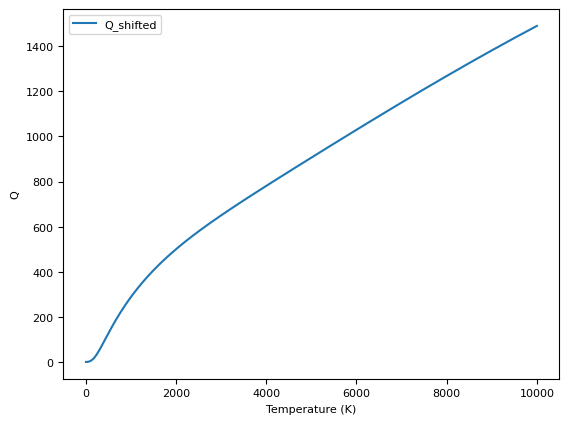

In [96]:
import matplotlib.pyplot as plt

k_B = 8.617e-5 # eV/K
temperature = np.linspace(1, 10000, 1000)
q = 0


energy_list = []

for id in all_ids:
    energy = calcs[id]['energy']/len(calcs[id]['forces'])
    #if energy > 0:
        #print(f"Energy is {energy} for id {id}, skipping")
        #continue
    #q += np.exp(-energy / (k_B * temperature))
    energy_list.append(energy)

e_min = np.min(np.array(energy_list))
shifted_energies = np.array(energy_list) - e_min

Q = []
Q_shifted = []
for temp in temperature:
    exp_terms = np.exp(-np.array(energy_list) / (k_B * temp))
    Q.append(np.sum(exp_terms))
    exp_terms_shifted = np.exp(-shifted_energies / (k_B * temp))
    Q_shifted.append(np.sum(exp_terms_shifted))



#plt.plot(temperature, Q, label="Q")
plt.plot(temperature, Q_shifted, label="Q_shifted")
plt.xlabel('Temperature (K)')
plt.ylabel('Q')
plt.legend()
plt.show()


In [93]:
from mace.calculators.mace import MACECalculator

atoms = db_manager.get_structure(20200)
model_paths = ['../potentials/mace_gen_6_ensemble/gen_7_model_0-2025-02-12_stagetwo_compiled.model', '../potentials/mace_gen_6_ensemble/gen_7_model_1-2025-02-12_stagetwo_compiled.model', '../potentials/mace_gen_6_ensemble/gen_7_model_2-2025-02-12_stagetwo_compiled.model']
calc = MACECalculator(model_paths, device='cpu',default_dtype='float32')

atoms.calc = calc
energy = atoms.get_potential_energy()/len(atoms)
print(energy)
prob = 1/Q * np.exp(-energy / (k_B * temperature))
prob_shifted = 1/Q_shifted * np.exp(-energy / (k_B * temperature))
print(prob)
print(prob_shifted)

/opt/homebrew/Caskroom/miniforge/base/envs/forge/lib/python3.11/site-packages/mace/calculators/mace.py:139: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)
/opt/homebrew/Caskroom/miniforge/base/envs/forge/lib/python3.11/site-packages/torch/serialization.py:1434: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn(


Running committee mace with 3 models
-9.364039755275106


TypeError: unsupported operand type(s) for /: 'int' and 'list'

/var/folders/p0/vc4k8wq14yx5wd2wvcxs3qhh0000gn/T/ipykernel_37996/3229242575.py:3: RuntimeWarning: overflow encountered in exp
  prob_shifted_list.append(1/Q_shifted[i] * np.exp(-energy / (k_B * temp)))


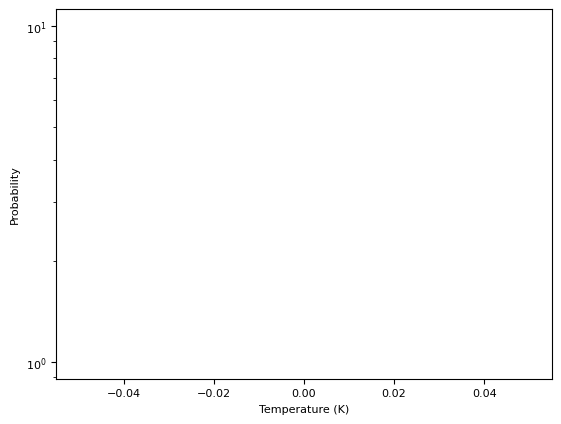

In [94]:
prob_shifted_list = []
for i,temp in enumerate(temperature):
    prob_shifted_list.append(1/Q_shifted[i] * np.exp(-energy / (k_B * temp)))


# remove the first 100 points
prob_shifted_list = prob_shifted_list[125:]
temperature = temperature[125:]

plt.plot(temperature, prob_shifted_list)
plt.yscale('log')
plt.xlabel('Temperature (K)')
plt.ylabel('Probability')
plt.show()


In [95]:
print(prob_shifted_list)

[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,

# Adding/implementing random shakes

In [15]:
gen_8_ids = db_manager.find_structures_by_metadata(metadata_filters={'generation' : '8'})

In [16]:
# get the unique parent_id values in these structures
gen_8_atoms = db_manager.get_batch_atoms_with_calculation(gen_8_ids)

In [17]:
parent_ids = [atoms.info['parent_id'] for atoms in gen_8_atoms]
unique_parent_ids = list(set(parent_ids))
print(len(unique_parent_ids))



10


In [18]:
# get the atoms for these parent ids
parent_atoms = db_manager.get_batch_atoms_with_calculation(unique_parent_ids)


In [21]:
print(parent_atoms[3])

Atoms(symbols='Zr2', pbc=True, cell=[[3.013764273, -0.204813379, -0.635579783], [-0.495777408, 2.836401624, 0.340714856], [-0.367607909, -0.04736912, 3.118686961]], forces=...)


In [26]:
pure_v = db_manager.find_structures(elements=['V'])


In [29]:
gen_6_ids = db_manager.find_structures_by_metadata(metadata_filters={'generation' : '6'})
gen_6_atoms = db_manager.get_batch_atoms_with_calculation(gen_6_ids)




In [30]:
def find_only_X_atoms(atoms_list, X_element):
    """
    Find structures in atoms_list that contain only the element X_element
    and no other elements.

    Args:
        atoms_list (list): List of ASE Atoms objects
        X_element (str): Element to check for
        
    """
    results_list = []
    for atoms in atoms_list:
        symbols = atoms.get_chemical_symbols()
        if symbols.count(X_element) == len(symbols):
            results_list.append(atoms)
    return results_list


pure_v = find_only_X_atoms(gen_6_atoms, 'V')

print(len(pure_v))

999


In [32]:
pure_w = find_only_X_atoms(gen_6_atoms, 'W')

print(len(pure_w))

996


In [33]:
print(len(gen_6_atoms))

1995


# Analyzing past AA 

In [89]:
import glob 
import os
from ase.io import read,write 
import numpy as np
from ase.visualize import view
import matplotlib.pyplot as plt

from forge.core.database import DatabaseManager

db_manager = DatabaseManager()

aa_path = '../scripts/adversarial_attacks/gen_8/'

xyz_files = glob.glob(os.path.join(aa_path, '*.xyz'))

In [91]:
# first, load in one of the .xyz files 

file_number = 1
atoms_list = read(xyz_files[file_number], index=':')

In [85]:
n = 1
print(atoms_list[n].calc.results['energy'])
print(type(atoms_list[n].info['structure_id']))
print(db_manager.get_calculations(int(atoms_list[n].info['structure_id']))[0]['energy'])

-10.158006477355958
<class 'numpy.int64'>
-9.908243


In [86]:
#print(len(atoms))
atoms_list[5].info['variance']

0.739263653755188

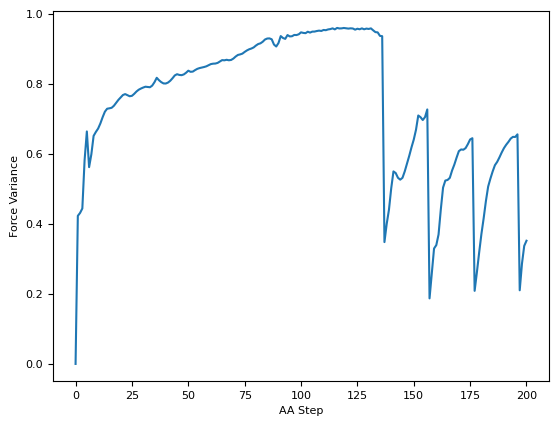

In [92]:
steps = np.arange(len(atoms_list))
variance = []
for i,atoms in enumerate(atoms_list):
    try:
        variance.append(atoms.info['variance'])
    except:
        variance.append(0)

plt.plot(steps, variance)
plt.xlabel('AA Step')
plt.ylabel('Force Variance')
plt.show()


[  5 116 156 176 196]
[0.6641287207603455, 0.9598442912101746, 0.7269167900085449, 0.644772469997406, 0.6557983160018921]


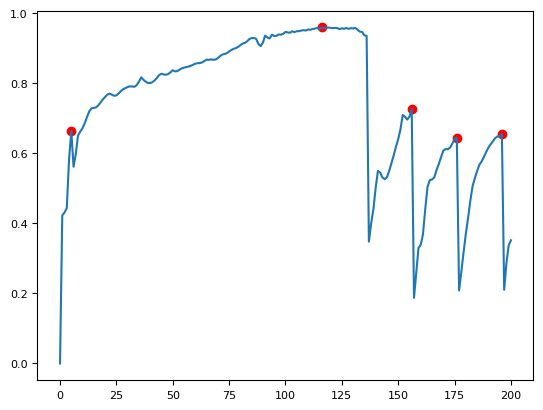

In [98]:
from scipy.signal import find_peaks 

peaks, properties = find_peaks(variance, prominence=0.1)

print(peaks)
peak_vals = [variance[i] for i in peaks]
print(peak_vals)


plt.plot(steps, variance)
plt.scatter(peaks, peak_vals, color='red')
plt.show()

(array([110, 114, 116, 119, 122, 125, 127, 129, 131]), {'peak_heights': array([0.95398158, 0.95858294, 0.95984429, 0.95969057, 0.95868731,
       0.95755297, 0.95850998, 0.95792776, 0.95852453])})


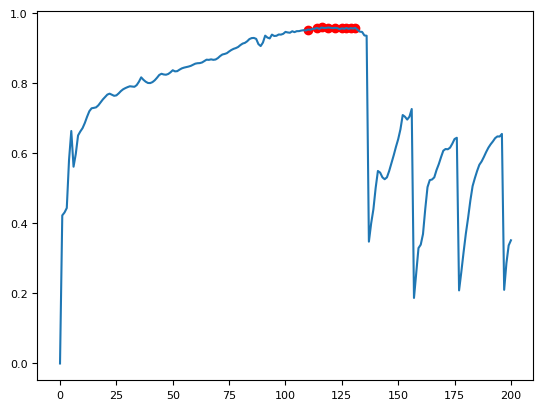

In [100]:
height_thresh = np.percentile(variance, 90)
peaks_by_height = find_peaks(variance, height=height_thresh)

print(peaks_by_height)

plt.plot(steps, variance)
plt.scatter(peaks_by_height[0], [variance[i] for i in peaks_by_height[0]], color='red')
plt.show()



[109, 113, 115, 118, 121, 124, 126, 128, 130]


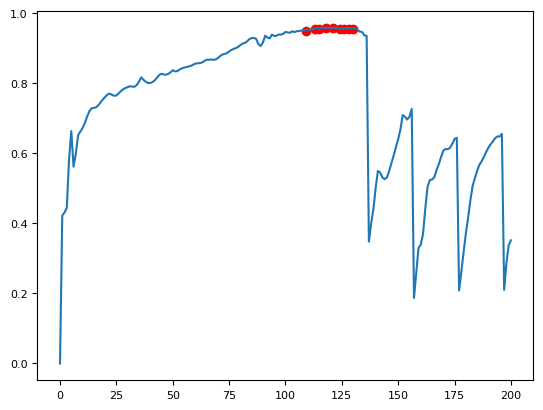

In [102]:
preceeding_points = [max(p - 1, 0) for p in peaks_by_height[0]]
print(preceeding_points)

plt.plot(steps, variance)
plt.scatter(preceeding_points, [variance[i] for i in preceeding_points], color='red')
plt.show()





[ 18  36  54  72  90 109 127 145 163 181]


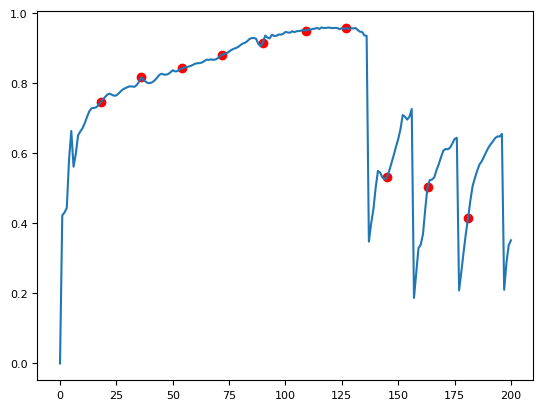

In [105]:
num_intermediate = 10  # adjustable
intermediate_points = np.linspace(0, len(variance)-1, num_intermediate+2, dtype=int)[1:-1]

print(intermediate_points)

plt.plot(steps, variance)
plt.scatter(intermediate_points, [variance[i] for i in intermediate_points], color='red')
plt.show()


Height peaks: [110 114 116 119 122 125 127 129 131]
Prominence peaks: (array([  5, 116, 156, 176, 196]), {'prominences': array([0.10202456, 0.77261271, 0.37888375, 0.43601881, 0.44542962]), 'left_bases': array([  0,   0, 137, 157, 157]), 'right_bases': array([  6, 157, 157, 177, 197])})
[5, 33, 66, 100, 110, 114, 116, 119, 122, 125, 133, 156, 166, 176, 196]


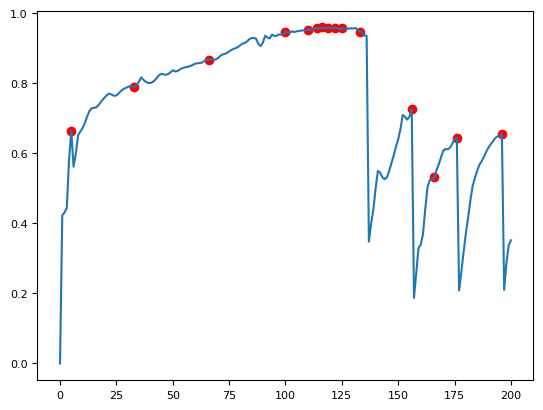

In [116]:
def sample_force_variance(force_variances, max_samples=15):

    prom_peaks = find_peaks(force_variances, prominence=0.1)
    height_thresh = np.percentile(force_variances, 90)
    height_peaks, _ = find_peaks(force_variances, height=height_thresh)

    print(f"Height peaks: {height_peaks}")
    print(f"Prominence peaks: {prom_peaks}")
    preceding_points = [max(p - 1, 0) for p in prom_peaks[0]]

    intermediate_points = np.linspace(0, len(force_variances)-1, int(max_samples/3)+2, dtype=int)[1:-1]

    all_indices = set(height_peaks.tolist() + prom_peaks[0].tolist() + preceding_points + intermediate_points.tolist())

    # If more points than allowed, prioritize peaks → preceding → intermediate
    priority_indices = prom_peaks[0].tolist() + intermediate_points.tolist() + height_peaks.tolist() + preceding_points
    sampled_indices = []
    for idx in priority_indices:
        if idx not in sampled_indices:
            sampled_indices.append(idx)
        if len(sampled_indices) >= max_samples:
            break

    return sorted(sampled_indices)


sampled_indices = sample_force_variance(variance)
print(sampled_indices)

plt.plot(steps, variance)
plt.scatter(sampled_indices, [variance[i] for i in sampled_indices], color='red')
plt.show()


# Allin one AA analysis

--- Original Data Plot ---


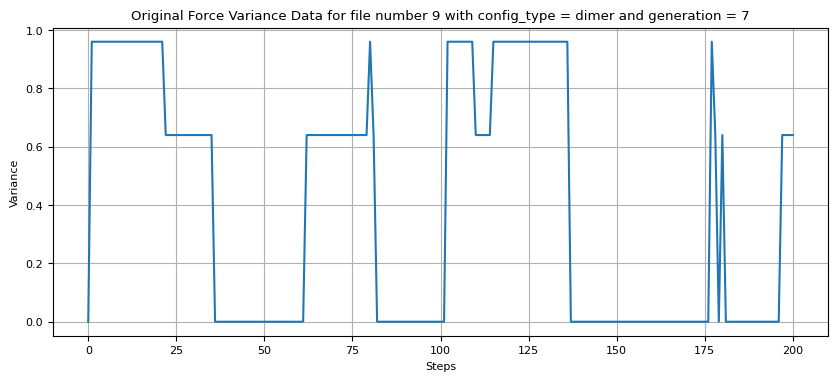


--- Sampling with Plotting ---


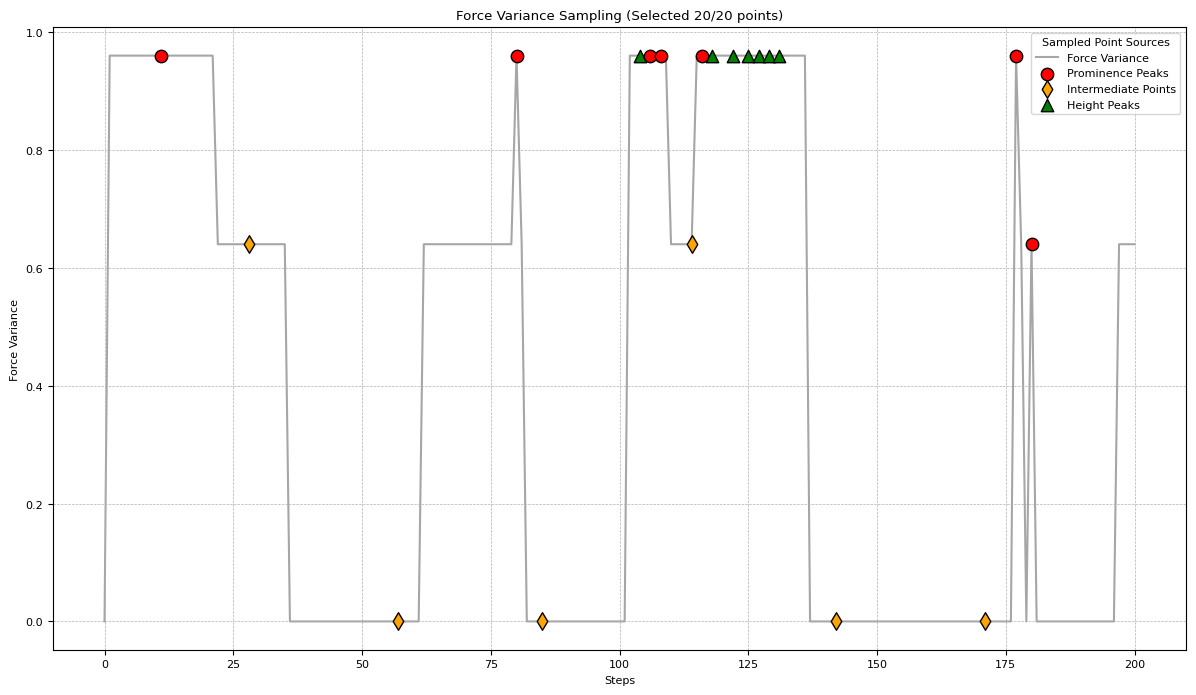


Final sampled indices: [11, 28, 57, 80, 85, 104, 106, 108, 114, 116, 118, 122, 125, 127, 129, 131, 142, 171, 177, 180]


In [132]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import glob 
import os
from ase.io import read,write 
import numpy as np
from ase.visualize import view
import matplotlib.pyplot as plt

from forge.core.database import DatabaseManager


def sample_force_variance(force_variances, steps=None, max_samples=15, plot=False):
    """
    Samples indices from force variance data based on peaks and intermediate points.

    Args:
        force_variances (np.array): Array of force variance values.
        steps (np.array, optional): Array of corresponding step numbers for plotting.
                                    Required if plot=True. Defaults to None.
        max_samples (int, optional): Maximum number of indices to sample. Defaults to 15.
        plot (bool, optional): Whether to generate a plot showing the sampling.
                               Defaults to False.

    Returns:
        list: Sorted list of sampled indices.
    """
    if plot and steps is None:
        raise ValueError("Argument 'steps' must be provided when plot=True.")
    if plot and len(steps) != len(force_variances):
        raise ValueError("Length of 'steps' must match length of 'force_variances' for plotting.")

    # --- Identify potential points from different sources ---
    prom_peaks_indices, _ = find_peaks(force_variances, prominence=0.1)
    height_thresh = np.percentile(force_variances, 90)
    height_peaks_indices, _ = find_peaks(force_variances, height=height_thresh)
    # Ensure preceding points are unique and non-negative
    preceding_points_indices = sorted(list(set(max(p - 1, 0) for p in prom_peaks_indices)))

    # Calculate intermediate points, ensuring they are within bounds and unique
    num_intermediate = int(max_samples / 3) # How many intermediate points to aim for
    if num_intermediate > 0:
        intermediate_points_indices = np.linspace(0, len(force_variances)-1, num_intermediate + 2, dtype=int)[1:-1]
    else:
        intermediate_points_indices = np.array([], dtype=int)

    # Store sources for potential points
    source_candidates = {
        'prominence': set(prom_peaks_indices),
        'height': set(height_peaks_indices),
        'preceding': set(preceding_points_indices),
        'intermediate': set(intermediate_points_indices)
    }

    # --- Select final points based on priority ---
    # Priority order: prominence -> intermediate -> height -> preceding
    priority_order = ['prominence', 'intermediate', 'height', 'preceding']
    final_sampled_indices = []
    sampled_indices_set = set()
    source_map = {} # Track the primary source for final sampled points

    for source_key in priority_order:
        # Get indices for the current source, sort them for consistent selection order
        current_source_indices = sorted(list(source_candidates[source_key]))

        for idx in current_source_indices:
            if len(final_sampled_indices) >= max_samples:
                break # Stop if max_samples reached
            if idx not in sampled_indices_set:
                final_sampled_indices.append(idx)
                sampled_indices_set.add(idx)
                source_map[idx] = source_key # Assign the source that selected it first
        if len(final_sampled_indices) >= max_samples:
             break # Stop outer loop if max_samples reached

    final_sampled_indices.sort() # Sort the final list

    # --- Plotting (optional) ---
    if plot:
        plt.figure(figsize=(12, 7))
        # Plot original data
        plt.plot(steps, force_variances, label='Force Variance', color='grey', alpha=0.7, zorder=1)

        # Define plotting styles for each source
        plot_styles = {
            'prominence': {'color': 'red', 'marker': 'o', 'label': 'Prominence Peaks'},
            'height': {'color': 'green', 'marker': '^', 'label': 'Height Peaks'},
            'preceding': {'color': 'purple', 'marker': 's', 'label': 'Preceding Prominence'},
            'intermediate': {'color': 'orange', 'marker': 'd', 'label': 'Intermediate Points'}
        }

        plotted_final_labels = set()

        # Plot the final selected points, colored by their source
        for idx in final_sampled_indices:
            source = source_map.get(idx, 'unknown') # Find the source
            style = plot_styles.get(source)
            if style:
                label = style['label'] if source not in plotted_final_labels else None
                plt.scatter(steps[idx], force_variances[idx],
                            color=style['color'], marker=style['marker'],
                            label=label, s=80, zorder=3, edgecolors='black') # Larger, bordered points for selected
                plotted_final_labels.add(source)
            else: # Fallback for unknown source (shouldn't happen with current logic)
                 plt.scatter(steps[idx], force_variances[idx], color='black', marker='x', label='Unknown Source', s=80, zorder=3)


        # Optionally, plot *all* candidate points with smaller markers/alpha
        # for source_key, indices_set in source_candidates.items():
        #     style = plot_styles.get(source_key)
        #     if style and indices_set:
        #         valid_indices = [i for i in indices_set if i < len(force_variances)]
        #         plt.scatter(steps[valid_indices], force_variances[valid_indices],
        #                     color=style['color'], marker=style['marker'], alpha=0.3, s=30, zorder=2)


        plt.xlabel("Steps")
        plt.ylabel("Force Variance")
        plt.title(f"Force Variance Sampling (Selected {len(final_sampled_indices)}/{max_samples} points)")
        if plotted_final_labels:
             plt.legend(title="Sampled Point Sources")
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

    return final_sampled_indices

# --- Example Usage ---
db_manager = DatabaseManager()

aa_path = '../scripts/adversarial_attacks/gen_8/'

xyz_files = glob.glob(os.path.join(aa_path, '*.xyz'))

file_number = 9 # Change this to get different files

atoms_list = read(xyz_files[file_number], index=':')
steps = np.arange(len(atoms_list))
variance = []
for i,atoms in enumerate(atoms_list):
    try:
        variance.append(atoms.info['variance'])
    except:
        variance.append(0)


# Original indices and plot
print("--- Original Data Plot ---")
plt.figure(figsize=(10, 4))
plt.plot(steps, variance)
plt.title("Original Force Variance Data for file number " + str(file_number) + " with config_type = " + str(atoms_list[0].info['config_type']) + " and generation = " + str(atoms_list[0].info['generation']))
plt.xlabel("Steps")
plt.ylabel("Variance")
plt.grid(True)
plt.show()

print("\n--- Sampling with Plotting ---")
# Call the function with plotting enabled
sampled_indices = sample_force_variance(variance, steps=steps, max_samples=20, plot=True)
print(f"\nFinal sampled indices: {sampled_indices}")

In [128]:
from ase.visualize import view
view(atoms_list[15], viewer='x3d')


# Take two


--- Sampling with Plateau Filtering and Plotting ---
Performing plateau filtering with displacement threshold 0.05 Å...
Removing 13 points due to similarity within plateaus: [85, 107, 111, 114, 116, 118, 121, 125, 127, 129, 133, 135, 142]


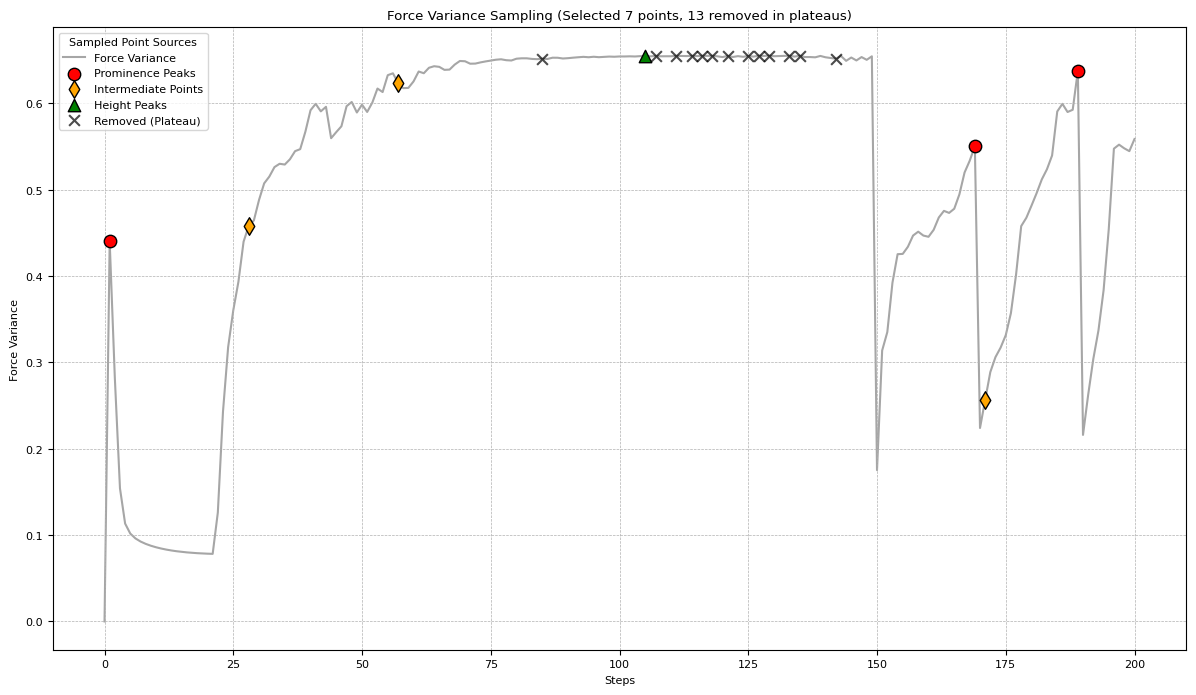


Final distinct sampled indices: [1, 28, 57, 105, 169, 171, 189]
Number of distinct points: 7

--- Sampling WITHOUT Plateau Filtering (for comparison) ---


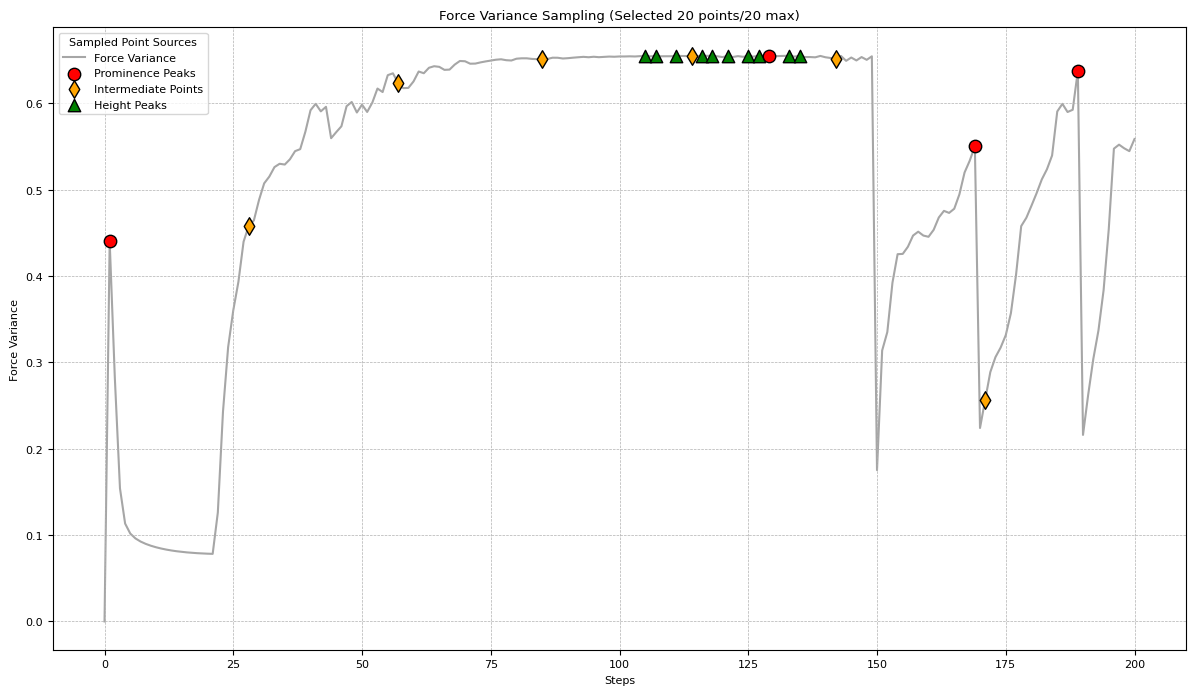


Sampled indices without filtering: [1, 28, 57, 85, 105, 107, 111, 114, 116, 118, 121, 125, 127, 129, 133, 135, 142, 169, 171, 189]
Number of points without filtering: 20


In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from ase import Atoms # Make sure Atoms is imported if not already

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import glob 
import os
from ase.io import read,write 
import numpy as np
from ase.visualize import view
import matplotlib.pyplot as plt

from forge.core.database import DatabaseManager

def find_plateaus(data, threshold):
    """Finds contiguous segments where the absolute difference is below a threshold."""
    diffs = np.abs(np.diff(data))
    in_plateau = diffs < threshold
    plateaus = []
    start_idx = -1
    for i in range(len(in_plateau)):
        if in_plateau[i] and start_idx == -1:
            start_idx = i # Plateau starts at the first point of the low-diff pair
        elif not in_plateau[i] and start_idx != -1:
            # Plateau ends at the second point of the last low-diff pair
            plateaus.append((start_idx, i))
            start_idx = -1
    # Handle plateau extending to the end
    if start_idx != -1:
        plateaus.append((start_idx, len(data) - 1))
    # Return segments as lists of indices
    plateau_indices = [list(range(start, end + 1)) for start, end in plateaus if end > start]
    return plateau_indices

def compare_atoms_displacement(atoms1, atoms2, min_displacement_threshold):
    """
    Compares two Atoms objects. Returns True if they are distinct enough, False otherwise.
    Distinct enough means max displacement >= min_displacement_threshold.
    Assumes atoms are ordered consistently.
    NOTE: This simple version doesn't robustly handle PBCs for displacement vectors.
          It's suitable if atoms don't cross boundaries significantly between compared steps.
    """
    if len(atoms1) != len(atoms2) or atoms1.get_chemical_symbols() != atoms2.get_chemical_symbols():
        return True # Different number or type of atoms -> distinct

    displacements = atoms2.positions - atoms1.positions
    # Basic PBC wrap - might not be perfect for large displacements across boundaries
    # For small steps within a plateau, it's often okay.
    # atoms1.wrap(displacements) # Use wrap method of one of the objects

    max_disp = np.max(np.linalg.norm(displacements, axis=1))

    return max_disp >= min_displacement_threshold

def sample_force_variance(
    force_variances,
    atoms_trajectory=None, # List of Atoms objects corresponding to variances
    steps=None,
    max_samples=15,
    plot=False,
    plateau_threshold=1e-4, # Threshold to define a variance plateau
    min_displacement_threshold=0.05 # Min Angstrom displacement to consider distinct
    ):
    """
    Samples indices from force variance data based on peaks and intermediate points,
    optionally filtering points within plateaus that are too similar structurally.

    Args:
        force_variances (np.array): Array of force variance values.
        atoms_trajectory (list[Atoms], optional): List of ASE Atoms objects for each step.
                                                  Required if plateau filtering is desired.
        steps (np.array, optional): Array of corresponding step numbers for plotting.
                                    Required if plot=True. Defaults to None.
        max_samples (int, optional): Maximum number of indices to sample. Defaults to 15.
        plot (bool, optional): Whether to generate a plot showing the sampling.
                               Defaults to False.
        plateau_threshold (float, optional): Max variance diff between consecutive points
                                             to be considered part of a plateau. Defaults to 1e-4.
        min_displacement_threshold (float, optional): Minimum max atomic displacement (Angstrom)
                                                      for points within a plateau to be kept. Defaults to 0.05.

    Returns:
        list: Sorted list of sampled indices.
    """
    n_points = len(force_variances)
    if plot and steps is None:
        raise ValueError("Argument 'steps' must be provided when plot=True.")
    if plot and len(steps) != n_points:
        raise ValueError("Length of 'steps' must match length of 'force_variances' for plotting.")
    if atoms_trajectory is not None and len(atoms_trajectory) != n_points:
         raise ValueError("Length of 'atoms_trajectory' must match length of 'force_variances'.")

    # --- Identify potential points from different sources ---
    prom_peaks_indices, _ = find_peaks(force_variances, prominence=0.1)
    height_thresh = np.percentile(force_variances, 90)
    height_peaks_indices, _ = find_peaks(force_variances, height=height_thresh)
    preceding_points_indices = sorted(list(set(max(p - 1, 0) for p in prom_peaks_indices)))

    num_intermediate = int(max_samples / 3)
    if num_intermediate > 0:
        intermediate_points_indices = np.linspace(0, n_points-1, num_intermediate + 2, dtype=int)[1:-1]
    else:
        intermediate_points_indices = np.array([], dtype=int)

    source_candidates = {
        'prominence': set(prom_peaks_indices),
        'height': set(height_peaks_indices),
        'preceding': set(preceding_points_indices),
        'intermediate': set(intermediate_points_indices)
    }

    # --- Initial Selection based on priority ---
    priority_order = ['prominence', 'intermediate', 'height', 'preceding']
    initial_sampled_indices = []
    initial_sampled_set = set()
    source_map = {}

    for source_key in priority_order:
        current_source_indices = sorted(list(source_candidates[source_key]))
        for idx in current_source_indices:
            if len(initial_sampled_indices) >= max_samples: break
            if idx not in initial_sampled_set:
                initial_sampled_indices.append(idx)
                initial_sampled_set.add(idx)
                source_map[idx] = source_key
        if len(initial_sampled_indices) >= max_samples: break

    initial_sampled_indices.sort()
    final_sampled_indices = list(initial_sampled_indices) # Start with initial selection
    indices_removed_plateau = set()

    # --- Plateau Filtering (if trajectory provided) ---
    if atoms_trajectory:
        print(f"Performing plateau filtering with displacement threshold {min_displacement_threshold} Å...")
        plateau_segments = find_plateaus(force_variances, plateau_threshold)
        # print(f"Found {len(plateau_segments)} plateau segments.")

        indices_to_potentially_remove = set()

        for plateau in plateau_segments:
            # Find which of the *initially* sampled points fall in this plateau
            sampled_in_plateau = sorted([idx for idx in initial_sampled_indices if idx in plateau])

            # print(f"  Plateau {plateau[0]}-{plateau[-1]}: Initially sampled points {sampled_in_plateau}")

            if len(sampled_in_plateau) > 1:
                last_kept_idx = sampled_in_plateau[0] # Always keep the first one
                for i in range(1, len(sampled_in_plateau)):
                    current_idx = sampled_in_plateau[i]
                    atoms1 = atoms_trajectory[last_kept_idx]
                    atoms2 = atoms_trajectory[current_idx]

                    if not compare_atoms_displacement(atoms1, atoms2, min_displacement_threshold):
                        # Current point is too similar to the last kept one, mark for removal
                        indices_to_potentially_remove.add(current_idx)
                        # print(f"    Marking index {current_idx} for removal (similar to {last_kept_idx})")
                    else:
                        # Current point is distinct enough, update the last kept point
                        last_kept_idx = current_idx
                        # print(f"    Keeping index {current_idx} (distinct from {sampled_in_plateau[i-1]})")


        # Remove the marked indices from the final list
        if indices_to_potentially_remove:
             print(f"Removing {len(indices_to_potentially_remove)} points due to similarity within plateaus: {sorted(list(indices_to_potentially_remove))}")
             final_sampled_indices = [idx for idx in initial_sampled_indices if idx not in indices_to_potentially_remove]
             indices_removed_plateau = indices_to_potentially_remove
        else:
             print("No points removed during plateau filtering.")


    # --- Plotting (optional) ---
    if plot:
        plt.figure(figsize=(12, 7))
        plt.plot(steps, force_variances, label='Force Variance', color='grey', alpha=0.7, zorder=1)

        plot_styles = {
            'prominence': {'color': 'red', 'marker': 'o', 'label': 'Prominence Peaks'},
            'height': {'color': 'green', 'marker': '^', 'label': 'Height Peaks'},
            'preceding': {'color': 'purple', 'marker': 's', 'label': 'Preceding Prominence'},
            'intermediate': {'color': 'orange', 'marker': 'd', 'label': 'Intermediate Points'}
        }
        removed_style = {'color': 'black', 'marker': 'x', 'label': 'Removed (Plateau)', 's': 60, 'zorder': 2, 'alpha': 0.7}

        plotted_final_labels = set()
        plotted_removed = False

        # Plot final selected points
        for idx in final_sampled_indices:
             # Check if this point was originally selected (it must have been)
            source = source_map.get(idx, 'unknown')
            style = plot_styles.get(source)
            if style:
                label = style['label'] if source not in plotted_final_labels else None
                plt.scatter(steps[idx], force_variances[idx],
                            color=style['color'], marker=style['marker'],
                            label=label, s=80, zorder=3, edgecolors='black')
                plotted_final_labels.add(source)
            else:
                 plt.scatter(steps[idx], force_variances[idx], color='blue', marker='*', label='Unknown Source', s=80, zorder=3) # Fallback


        # Plot points removed due to plateau similarity
        for idx in sorted(list(indices_removed_plateau)):
             label = removed_style['label'] if not plotted_removed else None
             plt.scatter(steps[idx], force_variances[idx],
                         color=removed_style['color'], marker=removed_style['marker'],
                         label=label, s=removed_style['s'], zorder=removed_style['zorder'], alpha=removed_style['alpha'])
             plotted_removed = True


        title = f"Force Variance Sampling (Selected {len(final_sampled_indices)} points"
        if atoms_trajectory:
             title += f", {len(indices_removed_plateau)} removed in plateaus)"
        else:
             title += f"/{max_samples} max)"

        plt.xlabel("Steps")
        plt.ylabel("Force Variance")
        plt.title(title)

        handles, labels = plt.gca().get_legend_handles_labels()
        # Create a unique legend
        by_label = dict(zip(labels, handles))
        if by_label:
             plt.legend(by_label.values(), by_label.keys(), title="Sampled Point Sources")

        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

    return sorted(final_sampled_indices)


# --- Example Usage ---
db_manager = DatabaseManager()

aa_path = '../scripts/adversarial_attacks/gen_8/'

xyz_files = glob.glob(os.path.join(aa_path, '*.xyz'))

file_number = 10 # Change this to get different files

atoms_list = read(xyz_files[file_number], index=':')
steps = np.arange(len(atoms_list))
variance = []
for i,atoms in enumerate(atoms_list):
    try:
        variance.append(atoms.info['variance'])
    except:
        variance.append(0)

# --- Run Sampling ---
print("\n--- Sampling with Plateau Filtering and Plotting ---")
sampled_indices = sample_force_variance(
    variance,
    atoms_trajectory=atoms_list, # Pass the trajectory
    steps=steps,
    max_samples=20,
    plot=True,
    plateau_threshold=0.05, # Adjust based on your data's noise level
    min_displacement_threshold=0.05 # Keep 0.05 Angstrom
)
print(f"\nFinal distinct sampled indices: {sampled_indices}")
print(f"Number of distinct points: {len(sampled_indices)}")

print("\n--- Sampling WITHOUT Plateau Filtering (for comparison) ---")
sampled_indices_no_filter = sample_force_variance(
    variance,
    atoms_trajectory=None, # Don't pass trajectory
    steps=steps,
    max_samples=20,
    plot=True,
)
print(f"\nSampled indices without filtering: {sampled_indices_no_filter}")
print(f"Number of points without filtering: {len(sampled_indices_no_filter)}")

## Playing with Mace

In [152]:
from mace.modules.models import MACE
from mace import data, modules, tools
import numpy as np
import torch
import torch.nn.functional
from e3nn import o3
from matplotlib import pyplot as plt
import ase.io
%matplotlib inline
from ase.visualize import view
from scipy.spatial.transform import Rotation

from mace.tools import torch_geometric
torch.set_default_dtype(torch.float64)
import warnings
warnings.filterwarnings("ignore")

# setup some default prameters
z_table = tools.AtomicNumberTable([22, 23, 24,40, 74])
e0s_str = {22: -2.15203187, 23 : -3.55411419, 24 : -5.42767241, 40 : -2.3361286, 74 : -4.55186158}
atomic_energies = np.array([e0s_str[z] for z in z_table.zs], dtype=float)
cutoff = 5.0

default_model_config = dict(
        num_elements=5,  # number of chemical elements
        atomic_energies=atomic_energies,  # atomic energies used for normalisation
        avg_num_neighbors=8,  # avg number of neighbours of the atoms, used for internal normalisation of messages
        atomic_numbers=z_table.zs,  # atomic numbers, used to specify chemical element embeddings of the model
        r_max=cutoff,  # cutoff
        num_bessel=8,  # number of radial features
        num_polynomial_cutoff=6,  # smoothness of the radial cutoff
        max_ell=2,  # expansion order of spherical harmonic adge attributes
        num_interactions=2,  # number of layers, typically 2
        interaction_cls_first=modules.interaction_classes[
            "RealAgnosticResidualInteractionBlock"
        ],  # interation block of first layer
        interaction_cls=modules.interaction_classes[
            "RealAgnosticResidualInteractionBlock"
        ],  # interaction block of subsequent layers
        hidden_irreps=o3.Irreps("8x0e "),  # 8: number of embedding channels, 0e, 1o is specifying which equivariant messages to use. Here up to L_max=1
        correlation=3,  # correlation order of the messages (body order - 1)
        MLP_irreps=o3.Irreps("16x0e"),  # number of hidden dimensions of last layer readout MLP
        gate=torch.nn.functional.silu,  # nonlinearity used in last layer readout MLP
    )
default_model = modules.MACE(**default_model_config)


In [153]:
embed_test_atoms = atoms_list[100].copy()

config = data.Configuration(
    atomic_numbers = embed_test_atoms.numbers,
    positions=embed_test_atoms.positions
)

batch = data.AtomicData.from_config(config, z_table, cutoff)
print("positions", batch.positions)
print("node_attrs", batch.node_attrs)
print("edge_index", batch.edge_index)

positions tensor([[0.8114, 1.0163, 0.9583],
        [2.7996, 0.6971, 2.9227],
        [2.8499, 2.6674, 1.0150],
        [0.8526, 2.3589, 2.8599],
        [3.6262, 3.3299, 3.9336],
        [5.5969, 5.1986, 5.7878]])
node_attrs tensor([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])
edge_index tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5],
        [1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3, 5, 4]])


In [154]:
vectors, lengths = modules.utils.get_edge_vectors_and_lengths(
    positions=batch['positions'],
    edge_index=batch['edge_index'],
    shifts=batch['shifts']
)

print(f'there are {batch.positions.shape[0]} nodes and {len(lengths)} edges')
print(f'lengths is shape {lengths.shape}')
print(f'vectors is shape {vectors.shape}')

there are 6 nodes and 22 edges
lengths is shape torch.Size([22, 1])
vectors is shape torch.Size([22, 3])


In [155]:
model = modules.MACE(**default_model_config)
initial_node_features = model.node_embedding(batch.node_attrs)
edge_features = model.radial_embedding(lengths, batch["node_attrs"], batch["edge_index"], z_table)
edge_attributes = model.spherical_harmonics(vectors)

print('initial_node_features is (num_atoms, num_channels):', initial_node_features.shape)
print('edge_features is (num_edge, num_bessel_func):', edge_features.shape)
print('edge_attributes is (num_edge, dimension of spherical harmonics):', edge_attributes.shape)
print(
    '\nInitial node features. Note that they are the same for each chemical element\n',
    initial_node_features
)

initial_node_features is (num_atoms, num_channels): torch.Size([6, 8])
edge_features is (num_edge, num_bessel_func): torch.Size([22, 8])
edge_attributes is (num_edge, dimension of spherical harmonics): torch.Size([22, 9])

Initial node features. Note that they are the same for each chemical element
 tensor([[ 0.1091, -0.6924,  0.1722,  0.7729,  0.6166, -0.8339,  0.8248, -0.1722],
        [ 0.1091, -0.6924,  0.1722,  0.7729,  0.6166, -0.8339,  0.8248, -0.1722],
        [ 0.1091, -0.6924,  0.1722,  0.7729,  0.6166, -0.8339,  0.8248, -0.1722],
        [ 0.1091, -0.6924,  0.1722,  0.7729,  0.6166, -0.8339,  0.8248, -0.1722],
        [ 0.1091, -0.6924,  0.1722,  0.7729,  0.6166, -0.8339,  0.8248, -0.1722],
        [ 0.1091, -0.6924,  0.1722,  0.7729,  0.6166, -0.8339,  0.8248, -0.1722]],
       grad_fn=<ViewBackward0>)


# UMAP with Mace Descriptors

In [165]:
from mace.calculators.mace import MACECalculator

model_paths = '../potentials/mace_gen_7_ensemble/job_gen_7-2025-04-14_model_0_pr_stagetwo.model'
calc = MACECalculator(model_paths=model_paths, default_dtype='float32', device='cpu')


test_atoms = atoms_list[20].copy()
descriptors = calc.get_descriptors(test_atoms, num_layers=-1, invariants_only=False)
print(descriptors)
print(descriptors.shape)
len(test_atoms)

[[-0.0159638   0.24695525  0.290004   ... -0.79878724 -0.68048114
  -0.0926723 ]
 [-0.04537424  0.23707415  0.28991896 ... -0.71739775 -0.72057104
  -0.06706575]
 [-0.04431013  0.24054602  0.2894735  ... -0.71678793 -0.7214494
  -0.06836283]
 [-0.01805404  0.2534109   0.27140385 ... -0.7388512  -0.70825946
  -0.07295863]
 [-1.4449553   0.6869546   1.1083822  ... -0.44991687 -0.21319343
   0.3404818 ]
 [-1.5785174   0.7361901   1.2102149  ... -0.4189118  -0.20789403
   0.3897487 ]]
(6, 256)


6

In [198]:
import numpy as np
from sklearn.cluster import KMeans
import umap # umap-learn package
import matplotlib.pyplot as plt
from ase import Atoms # Assuming ase.Atoms objects

# Keep the helper functions find_plateaus and compare_atoms_displacement if you still need them
# (They are not directly relevant to *this* specific error, but might be used later)

def select_diverse_high_variance_structures(
    atoms_list: list[Atoms],
    force_variances: list[float] | np.ndarray,
    atomic_embeddings: list[np.ndarray], # Now explicitly a list of N_atoms x embedding_dim arrays
    n_select: int,
    aggregation_method: str = 'mean', # Added: 'mean' or 'sum'
    umap_neighbors: int = 15,
    umap_min_dist: float = 0.1,
    random_state: int = 42,
    plot: bool = False
) -> list[int]:
    """
    Selects N diverse, high-uncertainty structures using embeddings and variance.

    Steps:
    1. Aggregate per-atom embeddings into per-structure embeddings (mean or sum).
    2. Apply UMAP for dimensionality reduction to 2D.
    3. Perform KMeans clustering on the 2D UMAP projection.
    4. Select the structure with the highest force variance from each cluster.

    Args:
        atoms_list: List of ASE Atoms objects.
        force_variances: List or array of force variance values for each structure.
        atomic_embeddings: List of per-atom embedding arrays (shape N_atoms x embedding_dim).
        n_select: The target number of diverse structures to select.
        aggregation_method: How to aggregate per-atom embeddings ('mean' or 'sum'). Defaults to 'mean'.
        umap_neighbors: UMAP hyperparameter: number of neighbors.
        umap_min_dist: UMAP hyperparameter: minimum distance between points.
        random_state: Random seed for UMAP and KMeans for reproducibility.
        plot: If True, generate a plot of the UMAP projection and selection.

    Returns:
        List of indices corresponding to the selected structures in the input lists.

    Raises:
        ValueError: If input list lengths do not match, n_select is invalid, or
                    aggregation_method is unknown.
    """
    n_structures = len(atoms_list)
    if not (n_structures == len(force_variances) == len(atomic_embeddings)):
        raise ValueError("Input lists (atoms_list, force_variances, atomic_embeddings) must have the same length.")
    if n_select <= 0:
        raise ValueError("n_select must be a positive integer.")
    if n_structures == 0:
        return []

    # --- Step 1: Aggregate Per-Atom Embeddings ---
    aggregated_embeddings = []
    embedding_dim = -1
    print(f"Aggregating per-atom embeddings using '{aggregation_method}' method...")
    for i, emb_array in enumerate(atomic_embeddings):
        if not isinstance(emb_array, np.ndarray) or emb_array.ndim != 2:
             raise ValueError(f"Item {i} in atomic_embeddings is not a 2D numpy array.")
        if embedding_dim == -1:
             embedding_dim = emb_array.shape[1]
        elif emb_array.shape[1] != embedding_dim:
             raise ValueError(f"Inconsistent embedding dimension found at index {i}. Expected {embedding_dim}, got {emb_array.shape[1]}.")

        if aggregation_method == 'mean':
            aggregated_embeddings.append(np.mean(emb_array, axis=0))
        elif aggregation_method == 'sum':
            aggregated_embeddings.append(np.sum(emb_array, axis=0))
        else:
            raise ValueError(f"Unknown aggregation_method: {aggregation_method}. Choose 'mean' or 'sum'.")

    # This will be the 2D array UMAP expects
    aggregated_embeddings_np = np.array(aggregated_embeddings) # Shape (n_structures, embedding_dim)
    print(f"Aggregation complete. Shape of aggregated embeddings: {aggregated_embeddings_np.shape}")


    # Handle case where fewer structures than requested are available AFTER aggregation
    if n_structures <= n_select:
        print(f"Warning: Number of structures ({n_structures}) is less than or equal to n_select ({n_select}). Returning all structure indices.")
        # Optional plotting remains similar, but uses aggregated_embeddings_np for UMAP
        if plot and n_structures > 0:
             try:
                  reducer = umap.UMAP(
                      n_neighbors=min(umap_neighbors, n_structures - 1) if n_structures > 1 else 1,
                      n_components=2,
                      min_dist=umap_min_dist,
                      random_state=random_state,
                      n_jobs=1,
                  )
                  # Use the aggregated embeddings here
                  embeddings_2d = reducer.fit_transform(aggregated_embeddings_np)

                  plt.figure(figsize=(10, 8))
                  scatter = plt.scatter(
                      embeddings_2d[:, 0], embeddings_2d[:, 1],
                      c=force_variances, cmap='viridis', s=50, alpha=0.7
                  )
                  plt.colorbar(scatter, label='Force Variance')
                  plt.title(f"UMAP Projection (All {n_structures} Points Selected)")
                  plt.xlabel("UMAP 1")
                  plt.ylabel("UMAP 2")
                  plt.grid(True, linestyle='--', alpha=0.5)
                  plt.show()
             except Exception as e:
                  print(f"Warning: Plotting failed for small dataset: {e}")
        return list(range(n_structures))

    # Ensure variance data is a numpy array
    variances_np = np.array(force_variances)

    # --- Step 2: Dimensionality Reduction with UMAP ---
    # Use the aggregated embeddings
    print(f"Running UMAP on {n_structures} aggregated embeddings (dim={aggregated_embeddings_np.shape[1]}) to 2D...")
    reducer = umap.UMAP(
        n_neighbors=umap_neighbors,
        n_components=2,
        min_dist=umap_min_dist,
        random_state=random_state,
        n_jobs=1,
    )
    embeddings_2d = reducer.fit_transform(aggregated_embeddings_np) # Use aggregated
    print("UMAP finished.")

    # --- Step 3: Clustering with KMeans ---
    n_clusters = n_select
    print(f"Running KMeans clustering with k={n_clusters} on 2D UMAP embeddings...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init='auto')
    cluster_labels = kmeans.fit_predict(embeddings_2d)
    print("KMeans finished.")

    # --- Step 4: Select Highest Variance from Each Cluster ---
    selected_indices_map = {} # {cluster_id: (best_variance, best_index)}
    for i in range(n_structures):
        cluster_id = cluster_labels[i]
        variance = variances_np[i]
        if cluster_id not in selected_indices_map or variance > selected_indices_map[cluster_id][0]:
            selected_indices_map[cluster_id] = (variance, i)

    final_selected_indices = sorted([data[1] for data in selected_indices_map.values()])

    num_actually_selected = len(final_selected_indices)
    if num_actually_selected < n_select:
        print(f"Warning: Only able to select {num_actually_selected} structures (expected {n_select}). Some clusters might have been empty.")

    # --- Step 5: Optional Plotting ---
    if plot:
        plt.figure(figsize=(12, 9))
        scatter_all = plt.scatter(
            embeddings_2d[:, 0], embeddings_2d[:, 1],
            c=cluster_labels, cmap='viridis', s=30, alpha=0.5, label='All Points (colored by cluster)'
        )
        selected_embeddings_2d = embeddings_2d[final_selected_indices]
        selected_variances = variances_np[final_selected_indices]

        scatter_selected = plt.scatter(
             selected_embeddings_2d[:, 0], selected_embeddings_2d[:, 1],
             c=selected_variances, cmap='coolwarm', s=100,
             edgecolors='black', marker='o',
             label=f'Selected (n={len(final_selected_indices)})', zorder=3
        )
        cbar = plt.colorbar(scatter_selected, label='Force Variance of Selected')
        cbar.ax.set_ylabel('Force Variance of Selected', fontsize=14)
        cbar.ax.tick_params(labelsize=14)  # Increase colorbar tick font size
        cbar.set_label('Force Variance of Selected', fontsize=14)  # Increase colorbar label font size
        plt.title(f"UMAP Projection (Aggregated='{aggregation_method}'), KMeans (k={n_clusters}), and High-Variance Selection", fontsize=18)
        plt.xlabel("UMAP Dimension 1", fontsize=14)
        plt.ylabel("UMAP Dimension 2", fontsize=14)
        plt.legend(fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    print(f"Selected {len(final_selected_indices)} diverse structures.")
    return final_selected_indices




Loading atoms from: ../scripts/adversarial_attacks/gen_8/structure_21686.xyz
Loaded 201 structures.
Calculating embeddings and extracting variances...
Number of variance entries: 201
Number of embedding entries: 201
Input counts: Structures=201
Aggregating per-atom embeddings using 'mean' method...
Aggregation complete. Shape of aggregated embeddings: (201, 256)
Running UMAP on 201 aggregated embeddings (dim=256) to 2D...
UMAP finished.
Running KMeans clustering with k=25 on 2D UMAP embeddings...
KMeans finished.


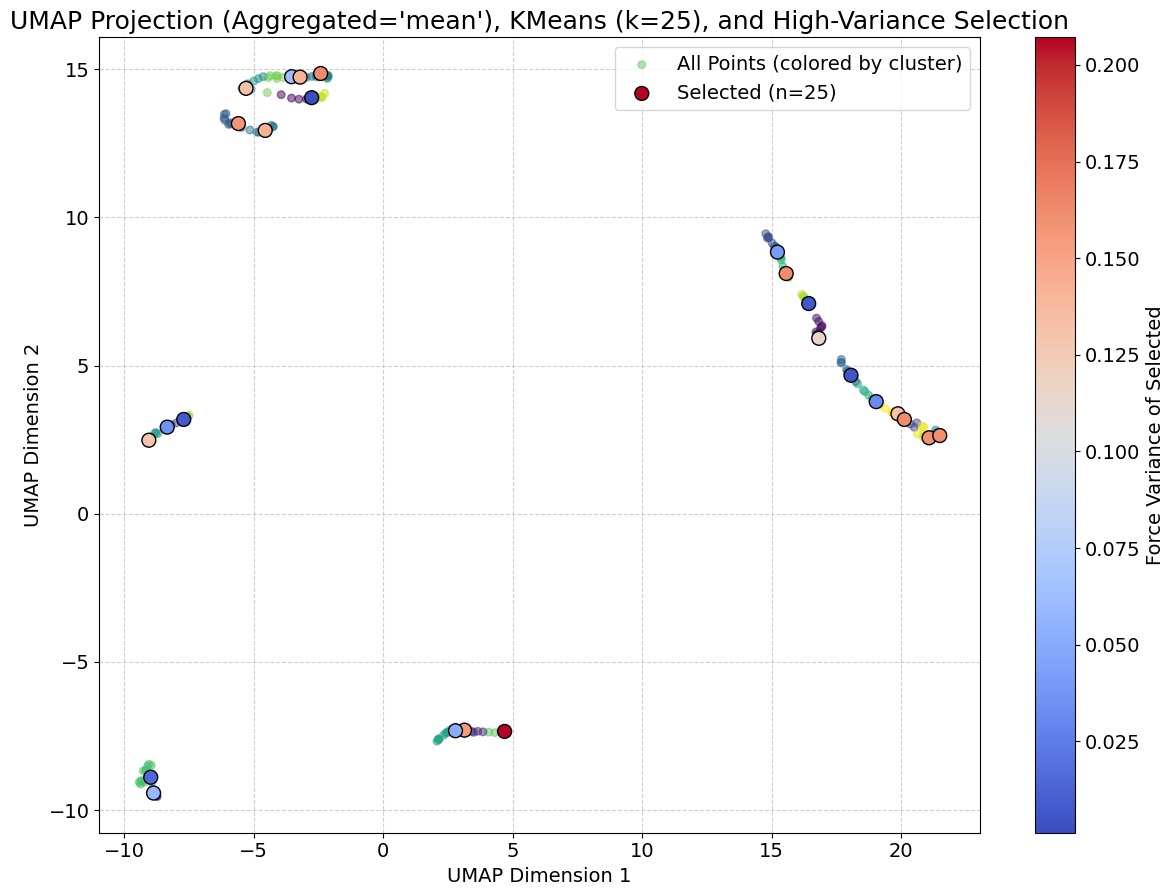

Selected 25 diverse structures.

Selected Indices: [3, 12, 14, 31, 34, 37, 52, 57, 71, 78, 91, 92, 97, 110, 114, 133, 142, 148, 152, 155, 156, 163, 183, 188, 200]
Selected 25 atoms.


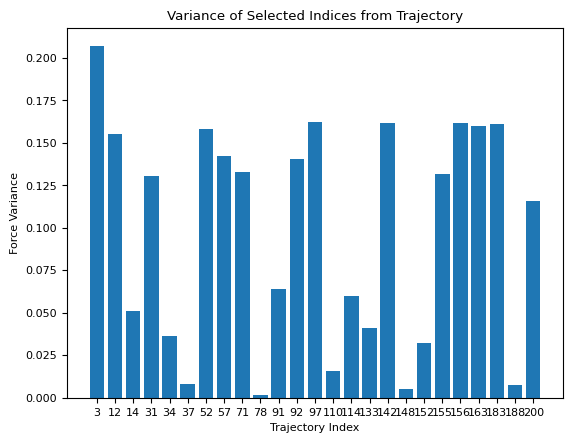

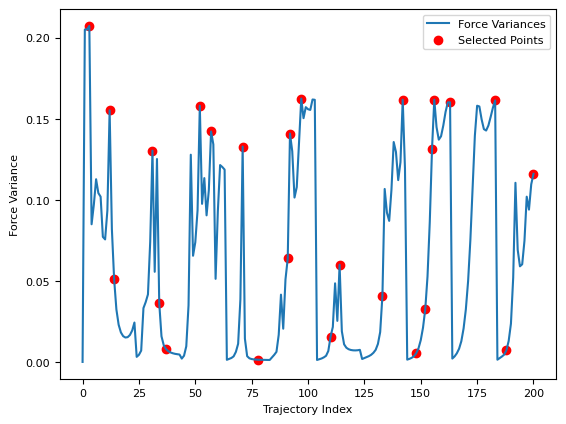

In [199]:
# --- Your Example Usage Code (Modified slightly for clarity) ---
import glob
import os
from ase.io import read
from forge.core.database import DatabaseManager # Assuming this is correct path
from mace.calculators.mace import MACECalculator

# Setup
model_paths = '../potentials/mace_gen_7_ensemble/job_gen_7-2025-04-14_model_0_pr_stagetwo.model'
calculator = MACECalculator(model_paths=model_paths, default_dtype='float32', device='cpu')
db_manager = DatabaseManager() # If needed for other things, otherwise remove
aa_path = '../scripts/adversarial_attacks/gen_8/'
N_SELECT = 25
file_number = 20 # Change this to get different files

# Load data
xyz_files = sorted(glob.glob(os.path.join(aa_path, '*.xyz'))) # Sort for consistency
if file_number >= len(xyz_files):
    print(f"Error: file_number {file_number} is out of range for found xyz files ({len(xyz_files)}).")
else:
    print(f"Loading atoms from: {xyz_files[file_number]}")
    atoms_list = read(xyz_files[file_number], index=':')
    print(f"Loaded {len(atoms_list)} structures.")

    # Extract variances and calculate embeddings
    variances = []
    raw_embeddings = [] # Store the list of (N_atoms, dim) arrays
    print("Calculating embeddings and extracting variances...")
    for i, atoms in enumerate(atoms_list):
        try:
            variances.append(atoms.info['variance'])
        except KeyError:
            print(f"Warning: 'variance' key not found in atoms.info for structure index {i}. Setting variance to 0.")
            variances.append(0.0) # Append float 0.0

        # Calculate per-atom embeddings
        # Ensure atoms object is suitable for calculator (e.g., has calculator assigned if needed by get_descriptors)
        try:
             # It's often better to pass the atoms object directly if the calculator supports it
             desc = calculator.get_descriptors(atoms)
             if desc is None or not isinstance(desc, np.ndarray) or desc.ndim != 2:
                  print(f"Warning: Received invalid descriptor (shape {desc.shape if isinstance(desc, np.ndarray) else type(desc)}) for structure index {i}. Skipping.")
                  # Need to handle this case - either skip the structure or assign a default
                  # For now, let's skip (requires adjusting list lengths later, or pre-filtering)
                  # A simpler approach for now might be to assign a zero vector, but this could skew UMAP
                  # Let's stick to raising an error if needed later, for now assume it returns correctly.
                  # If get_descriptors returns None, handle it
                  if desc is None:
                       raise ValueError(f"get_descriptors returned None for structure {i}")
             raw_embeddings.append(desc)
        except Exception as e:
             print(f"Error getting descriptors for structure index {i}: {e}")
             # Decide how to handle this error, e.g., skip the structure
             # For now, re-raise to stop execution if descriptors fail
             raise e


    variances_np = np.array(variances)
    # Note: raw_embeddings is a list of 2D arrays

    print(f"Number of variance entries: {len(variances_np)}")
    print(f"Number of embedding entries: {len(raw_embeddings)}")

    # Ensure consistency after potential errors/warnings
    if len(variances_np) != len(raw_embeddings):
         print("Error: Mismatch between number of variances and embeddings obtained. Exiting.")
         # Handle this appropriately - maybe filter atoms_list too if structures were skipped.
    else:
         N_STRUCTURES = len(atoms_list)
         print(f"Input counts: Structures={N_STRUCTURES}")
         # Pass the list of 2D arrays to the function
         selected_idx = select_diverse_high_variance_structures(
             atoms_list=atoms_list,
             force_variances=variances_np,
             atomic_embeddings=raw_embeddings, # Pass the list of (N, 256) arrays
             n_select=N_SELECT,
             aggregation_method='mean', # Specify aggregation
             plot=True,
             random_state=42
         )

         print("\nSelected Indices:", selected_idx)
         if selected_idx:
             selected_atoms = [atoms_list[i] for i in selected_idx]
             selected_vars = variances_np[selected_idx]
             print(f"Selected {len(selected_atoms)} atoms.")


selected_variances = [variances[idx] for idx in selected_idx]
plt.figure()
plt.bar(np.array(selected_idx, dtype='str'), selected_variances)
plt.xlabel('Trajectory Index')
plt.ylabel('Force Variance')
plt.title('Variance of Selected Indices from Trajectory')
plt.show()


plt.figure()
plt.plot(range(len(atoms_list)), variances, label='Force Variances')
plt.scatter(selected_idx, selected_variances, label='Selected Points', color='red')
plt.xlabel('Trajectory Index')
plt.ylabel('Force Variance')
plt.legend()
plt.show()

In [185]:
view(atoms_list[78], viewer='x3d')

silly_atom = atoms_list[78].copy()
silly_atom.calc = calculator
silly_atom.get_forces()
